In [1]:
!pip install captum

     |████████████████████████████████| 1.3 MB 13.6 MB/s eta 0:00:01


In [2]:
import torch
import torch.nn as nn
import torchvision
from datasets.SSL4EO.ssl4eo_dataset_lmdb_mm import LMDBDataset,random_subset
from cvtorchvision import cvtransforms
import numpy as np
import matplotlib.pyplot as plt

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, LayerActivation, LayerAttribution, IntegratedGradients

/p/project/hai_dm4eo/wang36/jupyter/kernels/wang36_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, season='fixed'):
        self.base_transform = base_transform
        self.season = season

    def __call__(self, x):

        if self.season=='augment':
            season1 = np.random.choice([0,1,2,3])
            season2 = np.random.choice([0,1,2,3])
        elif self.season=='fixed':
            np.random.seed(42)
            season1 = np.random.choice([0,1,2,3])
            season2 = season1
        elif self.season=='random':
            season1 = np.random.choice([0,1,2,3])
            season2 = season1

        x1 = np.transpose(x[season1,:,:,:],(1,2,0))
        #x2 = np.transpose(x[season2,:,:,:],(1,2,0))

        q = self.base_transform(x1)
        #k = self.base_transform(x2)

        #return [q, k]
        return q

In [4]:
data1 = '/p/project/hai_dm4eo/wang_yi/data/251k_sar.lmdb'
data2 = '/p/project/hai_dm4eo/wang_yi/data/251k_ms.lmdb'
season = 'fixed'

In [5]:
from models.rs_transforms_uint8 import RandomChannelDrop,RandomBrightness,RandomContrast,ToGray

train_transforms_s1 = cvtransforms.Compose([
    cvtransforms.CenterCrop(224),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(2)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_transforms_s2c = cvtransforms.Compose([
    cvtransforms.CenterCrop(224),
    #cvtransforms.Resize(128),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(13)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_dataset = LMDBDataset(
    lmdb_file_s1=data1,
    lmdb_file_s2=data2,
    s1_transform= TwoCropsTransform(train_transforms_s1,season=season),
    s2c_transform=TwoCropsTransform(train_transforms_s2c,season=season),
    is_slurm_job=True,
    normalize=False,
    dtype1='float32',
    dtype2='uint8',
    mode=['s1','s2c']
)   

In [6]:
class BarlowTwins_S1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone_1 = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone_2 = torchvision.models.resnet50(zero_init_residual=True)

        self.backbone_1.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)            
        self.backbone_2.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.backbone_1.fc = nn.Identity()
        self.backbone_2.fc = nn.Identity()

        # projector
        sizes = [2048] + list(map(int, '512-512-512'.split('-')))

        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector1 = nn.Sequential(*layers)
        self.projector2 = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, y1):
        z1 = self.projector1(self.backbone_1(y1))

        z1_c = z1[:,:448].mean(dim=-1,keepdim=True)
        z1_u = z1[:,448:].mean(dim=-1,keepdim=True)
        
        out = torch.cat((z1_c,z1_u),-1)
        
        return out

class BarlowTwins_S2(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone_1 = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone_2 = torchvision.models.resnet50(zero_init_residual=True)

        self.backbone_1.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)            
        self.backbone_2.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.backbone_1.fc = nn.Identity()
        self.backbone_2.fc = nn.Identity()

        # projector
        sizes = [2048] + list(map(int, '512-512-512'.split('-')))

        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector1 = nn.Sequential(*layers)
        self.projector2 = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, y2):
        z2 = self.projector2(self.backbone_2(y2))
        
        z2_c = z2[:,:448].mean(dim=-1,keepdim=True)
        z2_u = z2[:,448:].mean(dim=-1,keepdim=True)
        
        out = torch.cat((z2_c,z2_u),-1)

        return out

In [7]:
#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_p2/B2B13_bt_rn50/checkpoint_0099.pth'
#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_p2/B2B13_bt_decu_rn50/checkpoint_0099.pth'
#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_rn50/checkpoint_0099.pth'
resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_decu_rn50/checkpoint_0099.pth'

model1 = BarlowTwins_S1()
model2 = BarlowTwins_S2()
ckpt = torch.load(resume, map_location='cpu')
state_dict = ckpt['model']
state_dict = {k.replace("module.", ""): v for k,v in state_dict.items()}
model1.load_state_dict(state_dict)
model2.load_state_dict(state_dict)


<All keys matched successfully>

In [8]:
model1.eval()
model2.eval()
integrated_gradients_1 = IntegratedGradients(model1)
integrated_gradients_2 = IntegratedGradients(model2)

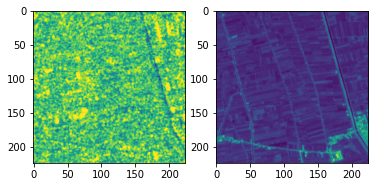

In [9]:
## visualize
id = 3
img_sar = train_dataset[id][0]
img_ms = train_dataset[id][1]

plt.subplot(1,2,1)
plt.imshow(img_sar[0])
plt.subplot(1,2,2)
plt.imshow(img_ms[2])


In [10]:
def normalize(data):
    p2,p98 = np.percentile(data,(2,98))
    data = np.clip(data,p2,p98)
    data = (data - data.min()) / (data.max()-data.min())
    return data

def get_rgb(data):
    r = normalize(data[3])
    g = normalize(data[2])
    b = normalize(data[1])
    rgb = np.stack((r,g,b),-1)
    return rgb
    

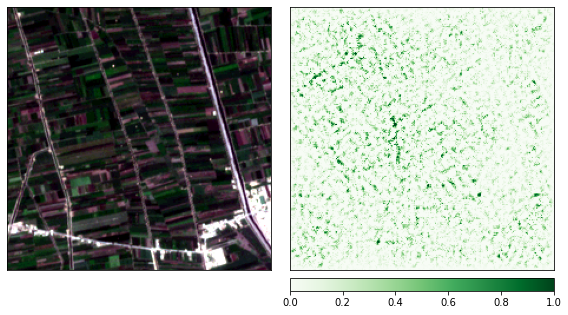

In [36]:
### common s2
input2 = img_ms.unsqueeze(0)
#attr_s2 = layer_gc_2.attribute(input2,target=0,relu_attributions=True)
#upsampled_attr_s2_c = LayerAttribution.interpolate(attr_s2, (264, 264))
attributions_ig_s2_c = integrated_gradients_2.attribute(input2, target=0, n_steps=50)


ori_img = get_rgb(input2[0].cpu().numpy())

plt_s2_c = viz.visualize_image_attr_multiple(
    attributions_ig_s2_c[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_img,
    signs=["all", "positive"],
    methods=["original_image", "heat_map"],
    show_colorbar=True)


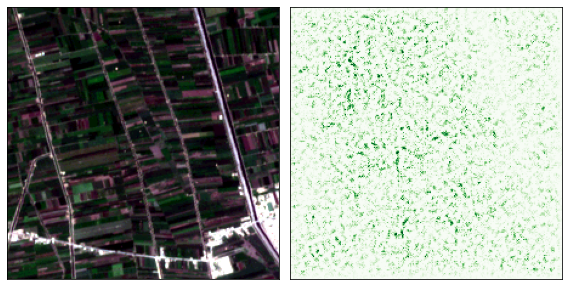

In [37]:
### unique s2
input2 = img_ms.unsqueeze(0)
#attr_s2 = layer_gc_2.attribute(input2,target=1,relu_attributions=True)
#upsampled_attr_s2_u = LayerAttribution.interpolate(attr_s2, (264, 264))
attributions_ig_s2_u = integrated_gradients_2.attribute(input2, target=1, n_steps=50)


ori_img = get_rgb(input2[0].cpu().numpy())

plt_s2_u = viz.visualize_image_attr_multiple(
    attributions_ig_s2_u[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=ori_img,
    signs=["all", "positive"],
    methods=["original_image", "heat_map"])

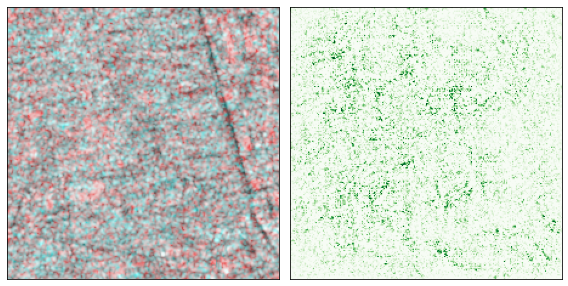

In [38]:
### common s1
input1 = img_sar.unsqueeze(0)
#attr_s1 = layer_gc_1.attribute(input1,0,relu_attributions=True)
#upsampled_attr_s1_c = LayerAttribution.interpolate(attr_s1, (264, 264))
attributions_ig_s1_c = integrated_gradients_1.attribute(input1, target=0, n_steps=50)

plt_s1_c = viz.visualize_image_attr_multiple(
    attributions_ig_s1_c[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=torch.stack((img_sar[0],img_sar[1],img_sar[1]),-1).numpy(),
    signs=["all", "positive"],
    methods=["original_image", "heat_map"])

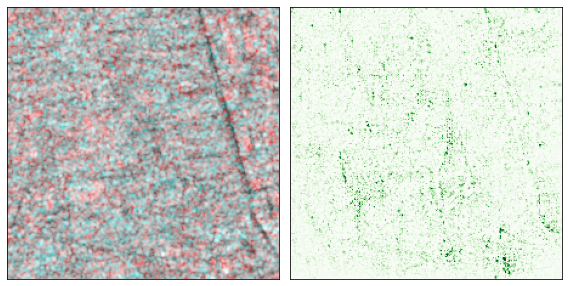

In [39]:
### unique s1
input1 = img_sar.unsqueeze(0)
#attr_s1 = layer_gc_1.attribute(input1,1,relu_attributions=True)
#upsampled_attr_s1_u = LayerAttribution.interpolate(attr_s1, (264, 264))
attributions_ig_s1_u = integrated_gradients_1.attribute(input1, target=1, n_steps=50)


plt_s1_u = viz.visualize_image_attr_multiple(
    attributions_ig_s1_u[0].cpu().permute(1,2,0).detach().numpy(),
    original_image=torch.stack((img_sar[0],img_sar[1],img_sar[1]),-1).numpy(),
    signs=["all", "positive"],
    methods=["original_image", "heat_map"])

In [40]:
attributions_ig_s2_c[attributions_ig_s2_c<0] = 0
attributions_ig_s2_u[attributions_ig_s2_u<0] = 0
attributions_ig_s1_c[attributions_ig_s1_c<0] = 0
attributions_ig_s1_u[attributions_ig_s1_u<0] = 0

print(attributions_ig_s2_c.mean(dim=(0,2,3)))
print(attributions_ig_s2_u.mean(dim=(0,2,3)))
print(attributions_ig_s1_c.mean(dim=(0,2,3)))
print(attributions_ig_s1_u.mean(dim=(0,2,3)))

tensor([1.7047e-05, 1.4070e-05, 1.5649e-05, 1.2161e-05, 1.5666e-05, 3.5707e-05,
        4.8760e-05, 5.0820e-05, 4.7617e-05, 1.0336e-05, 0.0000e+00, 2.9287e-05,
        1.3598e-05], dtype=torch.float64)
tensor([7.9397e-06, 7.1942e-06, 6.7470e-06, 5.5102e-06, 7.0972e-06, 1.6331e-05,
        2.1202e-05, 2.3810e-05, 2.5030e-05, 4.7901e-06, 0.0000e+00, 1.2561e-05,
        6.9745e-06], dtype=torch.float64)
tensor([1.3318e-05, 1.2725e-05], dtype=torch.float64)
tensor([1.2608e-05, 1.2075e-05], dtype=torch.float64)


In [41]:
print((attributions_ig_s2_c.mean(dim=(1)) * attributions_ig_s1_c.mean(dim=(1))).mean())
print((attributions_ig_s2_u.mean(dim=(1)) * attributions_ig_s1_u.mean(dim=(1))).mean())

tensor(3.3601e-10, dtype=torch.float64)
tensor(1.4582e-10, dtype=torch.float64)


In [16]:
##### count statistics
from tqdm import tqdm
#import scipy

#subset = random_subset(train_dataset,frac=0.1)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False,
    num_workers=10, drop_last=False)

all_band_attributions_ig_s2_c = torch.zeros(13)
all_band_attributions_ig_s2_u = torch.zeros(13)
all_band_attributions_ig_s1_c = torch.zeros(2)
all_band_attributions_ig_s1_u = torch.zeros(2)

pos_band_attributions_ig_s2_c = torch.zeros(13)
pos_band_attributions_ig_s2_u = torch.zeros(13)
pos_band_attributions_ig_s1_c = torch.zeros(2)
pos_band_attributions_ig_s1_u = torch.zeros(2)

out1_c = torch.zeros(1)
out1_u = torch.zeros(1)
out2_c = torch.zeros(1)
out2_u = torch.zeros(1)

count = 0
for i,data in enumerate(tqdm(train_loader)):
    if i>199:
        break
    img_sar = data[0]
    img_ms = data[1]

    ##
    out1 = model1(img_sar)
    out2 = model2(img_ms)
    out1_c += out1[0][0].abs()
    out1_u += out1[0][1].abs()
    out2_c += out2[0][0].abs()
    out2_u += out2[0][1].abs()
    
    '''
    attributions_ig_s2_c = integrated_gradients_2.attribute(img_ms, target=0, n_steps=50)
    attributions_ig_s2_u = integrated_gradients_2.attribute(img_ms, target=1, n_steps=50)
    attributions_ig_s1_c = integrated_gradients_1.attribute(img_sar, target=0, n_steps=50)
    attributions_ig_s1_u = integrated_gradients_1.attribute(img_sar, target=1, n_steps=50)
   
    ## all
    band_attributions_ig_s2_c = attributions_ig_s2_c.abs().mean(dim=(0,2,3))
    band_attributions_ig_s2_u = attributions_ig_s2_u.abs().mean(dim=(0,2,3))
    band_attributions_ig_s1_c = attributions_ig_s1_c.abs().mean(dim=(0,2,3))
    band_attributions_ig_s1_u = attributions_ig_s1_u.abs().mean(dim=(0,2,3))
    
    all_band_attributions_ig_s2_c += band_attributions_ig_s2_c
    all_band_attributions_ig_s2_u += band_attributions_ig_s2_u
    all_band_attributions_ig_s1_c += band_attributions_ig_s1_c
    all_band_attributions_ig_s1_u += band_attributions_ig_s1_u
    
    ## positive
    attributions_ig_s2_c[attributions_ig_s2_c<0] = 0
    attributions_ig_s2_u[attributions_ig_s2_u<0] = 0
    attributions_ig_s1_c[attributions_ig_s1_c<0] = 0
    attributions_ig_s1_u[attributions_ig_s1_u<0] = 0
    
    band_attributions_ig_s2_c = attributions_ig_s2_c.mean(dim=(0,2,3))
    band_attributions_ig_s2_u = attributions_ig_s2_u.mean(dim=(0,2,3))
    band_attributions_ig_s1_c = attributions_ig_s1_c.mean(dim=(0,2,3))
    band_attributions_ig_s1_u = attributions_ig_s1_u.mean(dim=(0,2,3))
    
    pos_band_attributions_ig_s2_c += band_attributions_ig_s2_c
    pos_band_attributions_ig_s2_u += band_attributions_ig_s2_u
    pos_band_attributions_ig_s1_c += band_attributions_ig_s1_c
    pos_band_attributions_ig_s1_u += band_attributions_ig_s1_u    
    '''
    count += 1
'''
np.save('results/all_band_attributions_ig_s2_c.npy',all_band_attributions_ig_s2_c)
np.save('results/all_band_attributions_ig_s2_u.npy',all_band_attributions_ig_s2_u)
np.save('results/all_band_attributions_ig_s1_c.npy',all_band_attributions_ig_s1_c)
np.save('results/all_band_attributions_ig_s1_u.npy',all_band_attributions_ig_s1_u)
np.save('results/pos_band_attributions_ig_s2_c.npy',pos_band_attributions_ig_s2_c)
np.save('results/pos_band_attributions_ig_s2_u.npy',pos_band_attributions_ig_s2_u)
np.save('results/pos_band_attributions_ig_s1_c.npy',pos_band_attributions_ig_s1_c)
np.save('results/pos_band_attributions_ig_s1_u.npy',pos_band_attributions_ig_s1_u)
np.save('results/out1_c.npy',out1_c.detach().numpy())
np.save('results/out1_u.npy',out1_u.detach().numpy())  
np.save('results/out2_c.npy',out2_c.detach().numpy())
np.save('results/out2_u.npy',out2_u.detach().numpy())
'''
'''
print(all_band_attributions_ig_s2_c)
print(all_band_attributions_ig_s2_u)
print(all_band_attributions_ig_s1_c)
print(all_band_attributions_ig_s1_u)
print(pos_band_attributions_ig_s2_c)
print(pos_band_attributions_ig_s2_u)
print(pos_band_attributions_ig_s1_c)
print(pos_band_attributions_ig_s1_u)
'''
print(out1_c,out1_u,out2_c,out2_u)

  0%|          | 200/251079 [01:49<38:16:50,  1.82it/s]

tensor([2.8845], grad_fn=<AddBackward0>) tensor([4.0850], grad_fn=<AddBackward0>) tensor([3.6449], grad_fn=<AddBackward0>) tensor([5.1553], grad_fn=<AddBackward0>)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
#all_band_attributions_ig_s1_c = np.load('results/all_band_attributions_ig_s1_c.npy')
#all_band_attributions_ig_s1_u = np.load('results/all_band_attributions_ig_s1_u.npy')
#all_band_attributions_ig_s2_c = np.load('results/all_band_attributions_ig_s2_c.npy')
#all_band_attributions_ig_s2_u = np.load('results/all_band_attributions_ig_s2_u.npy')
#pos_band_attributions_ig_s1_c = np.load('results/pos_band_attributions_ig_s1_c.npy')
#pos_band_attributions_ig_s1_u = np.load('results/pos_band_attributions_ig_s1_u.npy')
#pos_band_attributions_ig_s2_c = np.load('results/pos_band_attributions_ig_s2_c.npy')
#pos_band_attributions_ig_s2_u = np.load('results/pos_band_attributions_ig_s2_u.npy')

all_band_attributions_ig_s2_c = np.array([0.9191, 0.8514, 0.8609, 0.9383, 1.0034, 1.3556, 1.5867, 1.7643, 1.7719, 0.5030, 0.0033, 1.6810, 1.1144])
all_band_attributions_ig_s2_u = np.array([1.4073, 1.3498, 1.4344, 1.7070, 1.7657, 2.1951, 2.5117, 2.7890, 2.7912, 0.8215, 0.0050, 2.9186, 2.0389])

#all_band_max_s1 = np.stack([all_band_attributions_ig_s1_c, all_band_attributions_ig_s1_u]).max()
#all_band_min_s1 = np.stack([all_band_attributions_ig_s1_c, all_band_attributions_ig_s1_u]).min()
all_band_max_s2 = np.stack([all_band_attributions_ig_s2_c, all_band_attributions_ig_s2_u]).max()
all_band_min_s2 = np.stack([all_band_attributions_ig_s2_c, all_band_attributions_ig_s2_u]).min()

#all_band_attributions_ig_s1_c = (all_band_attributions_ig_s1_c - all_band_min_s1) / (all_band_max_s1 - all_band_min_s1)
#all_band_attributions_ig_s1_u = (all_band_attributions_ig_s1_u - all_band_min_s1) / (all_band_max_s1 - all_band_min_s1)
#all_band_attributions_ig_s2_c = (all_band_attributions_ig_s2_c - all_band_min_s2) / (all_band_max_s2 - all_band_min_s2)
#all_band_attributions_ig_s2_u = (all_band_attributions_ig_s2_u - all_band_min_s2) / (all_band_max_s2 - all_band_min_s2)

#all_band_attributions_ig_s1_c = all_band_attributions_ig_s1_c / all_band_max_s1
#all_band_attributions_ig_s1_u = all_band_attributions_ig_s1_u / all_band_max_s1
all_band_attributions_ig_s2_c = all_band_attributions_ig_s2_c / all_band_max_s2
all_band_attributions_ig_s2_u = all_band_attributions_ig_s2_u / all_band_max_s2


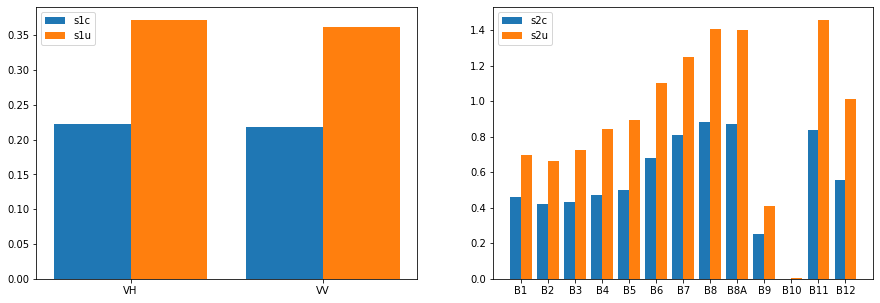

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
x_tick_s1 = ['VH','VV']
x_axis_s1 = np.arange(2)
plt.bar(x_axis_s1-0.2,pos_band_attributions_ig_s1_c,0.4,label='s1c')
plt.bar(x_axis_s1+0.2,pos_band_attributions_ig_s1_u,0.4,label='s1u')
plt.xticks(x_axis_s1, x_tick_s1)
plt.legend()
plt.subplot(1,2,2)
x_tick_s2 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
x_axis_s2 = np.arange(13)
plt.bar(x_axis_s2-0.2,pos_band_attributions_ig_s2_c,0.4,label='s2c')
plt.bar(x_axis_s2+0.2,pos_band_attributions_ig_s2_u,0.4,label='s2u')
plt.xticks(x_axis_s2, x_tick_s2)
plt.legend()

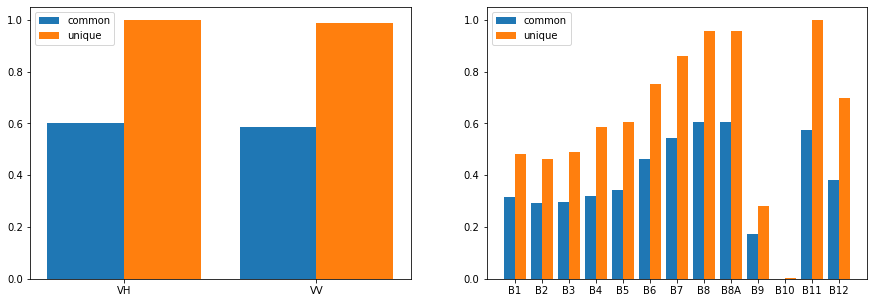

In [55]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
x_tick_s1 = ['VH','VV']
x_axis_s1 = np.arange(2)
plt.bar(x_axis_s1-0.2,all_band_attributions_ig_s1_c,0.4,label='common')
plt.bar(x_axis_s1+0.2,all_band_attributions_ig_s1_u,0.4,label='unique')
plt.xticks(x_axis_s1, x_tick_s1)
plt.legend()
plt.subplot(1,2,2)
x_tick_s2 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
x_axis_s2 = np.arange(13)
plt.bar(x_axis_s2-0.2,all_band_attributions_ig_s2_c,0.4,label='common')
plt.bar(x_axis_s2+0.2,all_band_attributions_ig_s2_u,0.4,label='unique')
plt.xticks(x_axis_s2, x_tick_s2)
plt.legend()

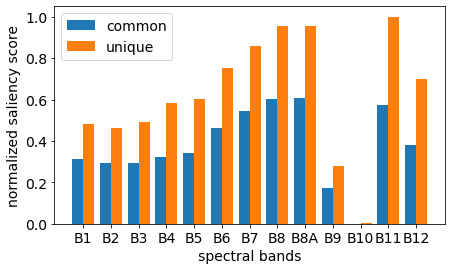

In [18]:
plt.figure(figsize=(7,4))
plt.rcParams["font.size"] = "14"
#plt.subplot(1,2,1)
#x_tick_s1 = ['VH','VV']
#x_axis_s1 = np.arange(2)
#plt.bar(x_axis_s1-0.2,all_band_attributions_ig_s1_c,0.4,label='common')
#plt.bar(x_axis_s1+0.2,all_band_attributions_ig_s1_u,0.4,label='unique')
#plt.xticks(x_axis_s1, x_tick_s1)
#plt.legend()
#plt.subplot(1,2,2)
x_tick_s2 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
x_axis_s2 = np.arange(13)
plt.bar(x_axis_s2-0.2,all_band_attributions_ig_s2_c,0.4,label='common')
plt.bar(x_axis_s2+0.2,all_band_attributions_ig_s2_u,0.4,label='unique')
plt.xticks(x_axis_s2, x_tick_s2)
plt.legend()
plt.xlabel('spectral bands')
plt.ylabel('normalized saliency score')
plt.savefig('results/IG_stats_S2.pdf',bbox_inches="tight")

In [56]:
out1_c = np.load('results/out1_c.npy')
out1_u = np.load('results/out1_u.npy')
out2_c = np.load('results/out2_c.npy')
out2_u = np.load('results/out2_u.npy')

In [58]:
print(out1_c,out1_u,out2_c,out2_u)
ratio_uc_1 = out1_u / out1_c
ratio_uc_2 = out2_u / out2_c

[326.0513] [497.4188] [388.7137] [583.8936]


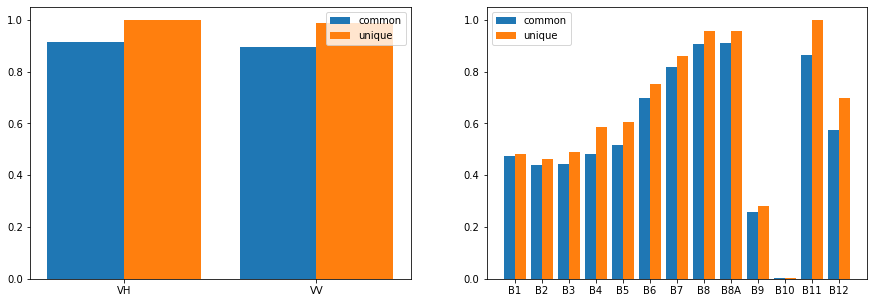

In [59]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
x_tick_s1 = ['VH','VV']
x_axis_s1 = np.arange(2)
plt.bar(x_axis_s1-0.2,all_band_attributions_ig_s1_c*ratio_uc_1,0.4,label='common')
plt.bar(x_axis_s1+0.2,all_band_attributions_ig_s1_u,0.4,label='unique')
plt.xticks(x_axis_s1, x_tick_s1)
plt.legend()
plt.subplot(1,2,2)
x_tick_s2 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
x_axis_s2 = np.arange(13)
plt.bar(x_axis_s2-0.2,all_band_attributions_ig_s2_c*ratio_uc_2,0.4,label='common')
plt.bar(x_axis_s2+0.2,all_band_attributions_ig_s2_u,0.4,label='unique')
plt.xticks(x_axis_s2, x_tick_s2)
plt.legend()